In [1]:
import pandas as pd
import numpy as np 
import re
% matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import pickle
import time

In [3]:
import spacy
nlp = spacy.load('en')

In [4]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

C:\Users\jgoldste\Anaconda2\envs\py35\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [6]:
# Update puncuation list in spacy
nlp.vocab["$"].is_punct = True
nlp.vocab["|"].is_punct = True
nlp.vocab["+"].is_punct = True
nlp.vocab["<"].is_punct = True
nlp.vocab[">"].is_punct = True
nlp.vocab["="].is_punct = True
nlp.vocab["^"].is_punct = True
nlp.vocab["`"].is_punct = True
nlp.vocab["~"].is_punct = True

In [7]:
clean_final = pd.read_csv("~/Documents/Capstone/code/clean_final_news.csv", encoding = "utf8", index_col = 0)

In [8]:
clean_final["binary_response"] = np.where(clean_final["response"] == "Not fake", 0, 1)

In [9]:
clean_final.head()

,author,published,text,domain_rank,site_url,spam_score,title,response,length,binary_response
0,SAM TANENHAUS,2016-11-20T03:51:00.000+02:00,Privacy Policy Eisenhowers two terms bore this...,98.0,nytimes.com,0.000,Opinion: Donald Trump’s Art of the New Deal?,Not fake,949,0
1,NaN,2016-11-20T00:52:00.000+02:00,Can Trump Save Their Jobs? by Nelson D. Sc...,98.0,nytimes.com,0.000,Carrier Workers for Trump,Not fake,372,0
2,Kathleen Elkins,2016-11-20T06:18:00.000+02:00,"Tuesday, 18 Oct 2016 | 10:25 AM ET CNBC.com Ed...",767.0,cnbc.com,0.008,Tennis star Caroline Wozniacki shares the mone...,Not fake,386,0
3,JEFF SOMMER,2016-11-20T00:04:00.000+02:00,Continue reading the main story Yet it is poss...,98.0,nytimes.com,0.000,Strategies: It’s Not Just the White House. Cha...,Not fake,1005,0
4,James Rufus Koren,2016-11-20T02:42:00.000+02:00,Wells Fargo hit with new sanctions following f...,609.0,latimes.com,0.264,Wells Fargo hit with new sanctions following f...,Not fake,809,0


### Preprocessing Functions

In [10]:
# Convert text and response to array 
x_text = clean_final.text.values
y_response = clean_final.binary_response.values

In [11]:
# Remove twitter handles from text 
for idx in range(len(x_text)):
    x_text[idx] = re.sub(r'@([A-Za-z0-9_]+)', "", str(x_text[idx]))

In [12]:
# Remove hyperlinks from text
for idx in range(len(x_text)):
    x_text[idx] = re.sub(r"(https|http)\S+", "", str(x_text[idx]))

In [13]:
# helper function to eliminate tokens that are pure punctuation, whitespace, or stopword
# can be updated based on desired filtering 

def process_txt(token):
    return token.is_punct or token.is_space or token.is_stop or token.like_num

In [14]:
# function to take array of articles and turn them into nested list of tokens

def lemmatize_txt(array):
    lemma = []
    
    for doc in nlp.pipe(array, batch_size=50,
                        n_threads=-1):
        if doc.is_parsed:
            lemma.append([n.lemma_ for n in doc if not process_txt(n)])
        
        else:
            lemma.append(None)
    
    return lemma

In [15]:
# function to recombine nested list of tokens into full articles 

def lemma_combine(lis):
    parsed_articles = []
    
    for i in range(len(lis)):
        concat_art = ' '.join(lis[i])
        parsed_articles.append(concat_art)
    
    return parsed_articles

In [16]:
# function to match "cleaned" text back up with response variable

def zip_response(observations, response):
    response = response.tolist()
    
    return list(zip(observations, response))

### Process Text

In [17]:
# Create nested list of tokens for each article
lem = lemmatize_txt(x_text)

In [18]:
# Create bi-grams for our text 
phrases = Phrases(lem)
bigram = Phraser(phrases)
bigram_lem = list(bigram[lem])

In [19]:
# Create tri-grams for our text
phrases2 = Phrases(bigram_lem)
trigram = Phraser(phrases2)
trigram_lem = list(trigram[bigram_lem])

In [18]:
# Recombine full article text for unigrams, bigrams, and trigrams
uni_lem_comb = lemma_combine(lem)
bi_lem_comb = lemma_combine(bigram_lem)
tri_lem_comb = lemma_combine(trigram_lem)

In [21]:
token_uni = "token_unigram_text"
fileObject = open(token_uni,'wb') 
pickle.dump(lem,fileObject)   
fileObject.close()

In [20]:
token_trigrams = "token_trigram_text"
fileObject = open(token_trigrams,'wb') 
pickle.dump(trigram_lem,fileObject)   
fileObject.close()

In [20]:
# Save processed text so it can be loaded later 
unigrams = "unigram_text"
fileObject = open(unigrams,'wb') 
pickle.dump(uni_lem_comb,fileObject)   
fileObject.close()

In [27]:
bigrams = "bigram_text"
fileObject = open(bigrams,'wb') 
pickle.dump(bi_lem_comb,fileObject)   
fileObject.close()

In [ ]:
trigrams = "trigram_text"
# open the file for writing
fileObject = open(trigrams,'wb') '
pickle.dump(tri_lem_comb,fileObject)   
fileObject.close()

### Reload processed text

In [27]:
fileObject = open('unigram_text','rb')  
uni_lem_comb2 = pickle.load(fileObject)  

In [28]:
fileObject = open('bigram_text','rb')  
bi_lem_comb2 = pickle.load(fileObject)  

In [5]:
fileObject = open('trigram_text','rb')  
tri_lem_comb2 = pickle.load(fileObject)  

In [6]:
tri_lem_comb2[1:5]

["trump save jobs nelson d. schwartz nov. look worker carrier_plant indianapolis soon close production move_mexico worker interview speak support donald_j._trump article attract comment follow edit_condense mr._trump not save job nafta_free_trade agreement keep economy_grow underlying dynamic change underlying dynamic have_get better automation b big era american growth doug boulder heartbreaking read people people victim change victim technological revolution victim global_economy victim economy people want pay money possible good company produce product want profit possible trump con single job not come claudia piepenburg vista calif. mr._trump save carrier worker job willing work wage company pay mexican worker scott new_york worker sadly disappointed twice carrier move mr._trump anticipate confusion grief buyer_remorse work force advertisement susan michigan not mr._trump set good example c.e.o.s order company start make product u.s. right lead example mr._trump rita california def

### Prepare Model

In [22]:
def evaluate_model(clf, actual, predicted):
    report = metrics.classification_report(actual, predicted, target_names = ["0", "1"])
    matrix = confusion_matrix(actual, predicted)
    train_loss = metrics.log_loss(y_train, clf.predict_proba(x_train))
    test_loss = metrics.log_loss(y_test, clf.predict_proba(x_test))
    
    print("Train score:", train_loss)
    print("Test score:", test_loss)
    print("Confusion Matrix\n", matrix)
    print("Classification Report:\n", report)
    
    return test_loss

In [23]:
# Split test and train data using trigram text
x_train, x_test, y_train, y_test = train_test_split(tri_lem_comb2, y_response, test_size = 0.2, stratify = y_response)

In [40]:
x_train

["let_friend_social_network know_read_facebook email search resume miss indonesia_boat sink people boat miss post_facebook search resume miss indonesia_boat sink people boat miss check_story_usatoday.com_cancel send_link_send_friend 's_email_address post_link_post_facebook feed_join_nation_'s conversation_find_facebook_comment read_conversation_guidelines_faq search resume miss indonesia_boat sinking associated_press 2:59 a.m._edt_november indonesian rescuer evacuate body victim sink boat mata ikan bay batam riau islands indonesia nov._photo m urip epa jakarta_indonesia_indonesian rescue authority thursday resume search people miss sinking overcrowded speedboat day_earlier search effort suspend nightfall wednesday start daylight personnel involve say sutopo purwo nugroho head countrys disaster mitigation agency eighteen body identify people rescue accord agency people boat miss sutopo say boat carry indonesian worker home malaysia capsize indonesian_island batam a.m. wednesday stormy_w

### Naive Bayes Model

In [48]:
# Set up pipeline to run TFIDF and Naive Bayes
text_pipe_nb = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

In [49]:
text_pipe_nb.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [22]:
# Use pipeline to predict on train data and find accuracy - no grid search
#predicted_train = text_pipe.predict(x_train)
#np.mean(predicted_train == y_train) 

0.83021525570644328

In [23]:
# Use pipeline to predict on test data and find accuracy - no grid search 
#predicted = text_pipe.predict(x_test)
#np.mean(predicted == y_test) 

0.79806442293803259

In [24]:
# Get more detailed performance metrics - no grid search
print(metrics.classification_report(y_test, predicted, target_names = ["Not fake", "fake"]))

             precision    recall  f1-score   support

   Not fake       0.77      1.00      0.87      4715
       fake       0.99      0.37      0.54      2208

avg / total       0.84      0.80      0.76      6923



In [50]:
# Set up grid search to find best parameters for TFIDF and MNB
parameters = {'tfidf__max_df': (0.75, 0.80, 0.85, 0.90, 0.95, 1.0),\
              'tfidf__min_df': (0.001,0.01,0.1),\
              'nb__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}

In [51]:
# Establish grid search instance
gs_nb = GridSearchCV(text_pipe_nb, parameters, n_jobs=-1, scoring = 'f1')

In [52]:
%%time 
# Fit grid search to train data and find best parameters
gs_nb = gs_nb.fit(x_train, y_train)

Train score: 0.172519814274
Test score: 0.212836566076


0.21283656607574009

In [53]:
# Check best parameters
gs_nb.best_params_

{'clf__alpha': 1e-05, 'tfidf__max_df': 0.75, 'tfidf__min_df': 0.001}

In [30]:
# Predict on test data
nb_predicted = gs_nb.predict(x_test)

0.90423226924743605

In [31]:
# Produce confusion matrix and classification report for nb model
evaluate_model(gs_nb, y_test, nb_predicted)

             precision    recall  f1-score   support

   Not fake       0.91      0.95      0.93      4715
       fake       0.88      0.81      0.84      2208

avg / total       0.90      0.90      0.90      6923



In [68]:
filename = 'nb_model.sav'
pickle.dump(gs_nb, open(filename, 'wb'))
filename.close()

NameError: name 'gs_nb' is not defined

### Logistic Regression Model

In [42]:
text_pipe_lr = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression())])

In [43]:
text_pipe_lr.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [44]:
# Set up grid search to find best parameters for TFIDF and LogReg
lr_parameters = {'tfidf__max_df': (0.75, 0.80, 0.85, 0.90, 0.95, 1.0),\
              'tfidf__min_df': (0.001,0.01,0.1),\
              'lr__penalty': ('l1','l2'),\
                'lr__C': (0.01, 0.1, 1),\
                'lr__class_weight': (None, 'balanced')}

In [45]:
# Establish grid search instance for log reg
gs_lr = GridSearchCV(text_pipe_lr, lr_parameters, n_jobs=-1, scoring='f1')

In [46]:
%%time 
# Fit grid search to train data and find best parameters
gs_lr = gs_lr.fit(x_train, y_train)

Wall time: 1h 13min 21s


In [47]:
# Get best parameters for log reg
gs_lr.best_params_

{'lr__C': 1,
 'lr__class_weight': 'balanced',
 'lr__penalty': 'l2',
 'tfidf__max_df': 0.75,
 'tfidf__min_df': 0.001}

In [48]:
# Predict on test data 
lr_predicted = gs_lr.predict(x_test)

In [52]:
# Produce confusion matrix and classification report for lr model
evaluate_model(gs_lr, y_test, lr_predicted)

Train score: 0.199665811636
Test score: 0.237676017458
Confusion Matrix
 [[4373  342]
 [ 202 2006]]
Classification Report:
              precision    recall  f1-score   support

          0       0.96      0.93      0.94      4715
          1       0.85      0.91      0.88      2208

avg / total       0.92      0.92      0.92      6923



0.23767601745789554

In [54]:
train_loss = metrics.roc_auc_score(y_train, gs_lr.predict(x_train))
test_loss = metrics.roc_auc_score(y_test, gs_lr.predict(x_test))
print("Train score:", train_loss)
print("Test score:", test_loss)

Train score: 0.955096607469
Test score: 0.917990014139


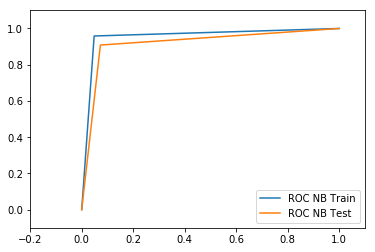

In [60]:
A=metrics.roc_curve(y_train,gs_lr.predict(x_train),pos_label=1)
B=metrics.roc_curve(y_test,gs_lr.predict(x_test),pos_label=1)

plt.plot(A[0],A[1],label='ROC NB Train')
plt.plot(B[0],B[1],label='ROC NB Test')
plt.xlim((-0.2,1.1))
plt.ylim((-0.1,1.1))
plt.legend(loc=4)

In [70]:
filename = 'lr_model.sav'
pickle.dump(gs_lr, open(filename, 'wb'))

### Random Forest

In [24]:
text_pipe_rf = Pipeline([('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])

In [25]:
text_pipe_rf.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [26]:
# Set up grid search to find best parameters for TFIDF and RF
rf_parameters = {'tfidf__max_df': (0.75, 0.80, 0.85, 0.90, 0.95, 1.0),\
              'tfidf__min_df': (0.001,0.01,0.1),\
              'rf__n_estimators': (50, 100, 200),\
                'rf__criterion': ('gini', 'entropy'),\
                'rf__class_weight': (None, 'balanced'),\
                'rf__min_samples_split': (10,20,30)}

In [27]:
# Establish grid search instance for log reg
gs_rf = GridSearchCV(text_pipe_rf, rf_parameters, n_jobs=-1, scoring='f1')

In [28]:
%%time 
# Fit grid search to train data and find best parameters
gs_rf = gs_rf.fit(x_train, y_train)

KeyboardInterrupt: 

In [24]:
# Get best parameters for log reg
gs_rf.best_params_

{'rf__class_weight': 'balanced',
 'rf__criterion': 'entropy',
 'rf__n_estimators': 200,
 'tfidf__max_df': 0.85,
 'tfidf__min_df': 0.001}

In [25]:
# Predict on test data 
rf_predicted = gs_rf.predict(x_test)

In [26]:
evaluate_model(gs_rf, y_test, rf_predicted)

Train score: 0.0927214376178
Test score: 0.296447461285
Confusion Matrix
 [[4582  133]
 [ 467 1741]]
Classification Report:
              precision    recall  f1-score   support

          0       0.91      0.97      0.94      4715
          1       0.93      0.79      0.85      2208

avg / total       0.91      0.91      0.91      6923



0.29644746128478461

In [27]:
train_loss = metrics.roc_auc_score(y_train, gs_rf.predict(x_train))
test_loss = metrics.roc_auc_score(y_test, gs_rf.predict(x_test))
print("Train score:", train_loss)
print("Test score:", test_loss)

Train score: 1.0
Test score: 0.880144264758


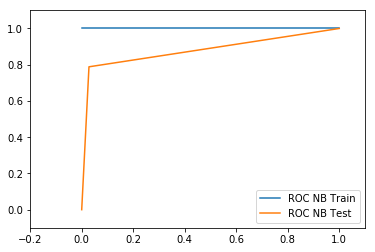

In [28]:
A=metrics.roc_curve(y_train,gs_rf.predict(x_train),pos_label=1)
B=metrics.roc_curve(y_test,gs_rf.predict(x_test),pos_label=1)

plt.plot(A[0],A[1],label='ROC NB Train')
plt.plot(B[0],B[1],label='ROC NB Test')
plt.xlim((-0.2,1.1))
plt.ylim((-0.1,1.1))
plt.legend(loc=4)

In [29]:
filename = 'rf_model.sav'
pickle.dump(gs_rf, open(filename, 'wb'))

### SVM Model

In [ ]:
text_pipe_svm = Pipeline([('tfidf', TfidfVectorizer()), ('svm', SVC())])

In [ ]:
text_pipe_svm.fit(x_train,y_train)

In [32]:
# Set up grid search to find best parameters for TFIDF and SVM
svm_parameters = {'tfidf__max_df': (0.75, 0.80, 0.85, 0.90, 0.95, 1.0),\
              'tfidf__min_df': (0.001,0.01,0.1),\
              'svm__C': (1, 10, 100, 1000),\
                'svm__degree': (1 , 2, 3),\
                'svm__class_weight': (None, 'balanced')}

In [ ]:
# Establish grid search instance for SVM
gs_svm = GridSearchCV(text_pipe_svm, svm_parameters, n_jobs=-1, scoring='f1')

In [ ]:
%%time 
# Fit grid search to train data and find best parameters
gs_svm = gs_svm.fit(x_train, y_train)

In [ ]:
# Get best parameters for SVM
gs_svm.best_params_

In [ ]:
# Predict on test data 
svm_predicted = gs_svm.predict(x_test)

In [ ]:
evaluate_model(gs_svm, y_test, svm_predicted)